In [1]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp


import os

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'

# IR models

Here are just some basics of IR modeling.

$R(t, T) = -\frac{\ln P(t, T)}{T-t} \Rightarrow P(t, T) = e^{-R(t, T)(T-t)}$, where $R(t, T) - \text{ZCYC}$, 
$P(t, T) - \text{ZCB};$

To make $R(t, T) $ and $P(t, T)$ - continuous and differentiable we interpolate them with cubic splines.

$f(0, T) = \frac{\partial R(0, T)}{\partial T}T + R(0, T)$ - forward rate

In [2]:
#Deepseek realization of scipy.interpolate.CubicSpline using JAX
#Produce almost the same result as scipy
def create_cubic_spline_interpolator(x_data, y_data, bc_type='not-a-knot'):
    x_data = jnp.asarray(x_data)
    y_data = jnp.asarray(y_data)
    n = x_data.shape[0]
    h = x_data[1:] - x_data[:-1]
    delta = (y_data[1:] - y_data[:-1]) / h

    # Build tridiagonal system for not-a-knot boundary conditions
    if bc_type == 'not-a-knot':
        A = jnp.zeros((n, n))
        rhs = jnp.zeros(n)
        A = A.at[0, 0].set(h[1])
        A = A.at[0, 1].set(-(h[0] + h[1]))
        A = A.at[0, 2].set(h[0])
        A = A.at[-1, -3].set(h[-2])
        A = A.at[-1, -2].set(-(h[-2] + h[-1]))
        A = A.at[-1, -1].set(h[-1])
        for i in range(1, n-1):
            A = A.at[i, i-1].set(h[i-1])
            A = A.at[i, i].set(2*(h[i-1] + h[i]))
            A = A.at[i, i+1].set(h[i])
            rhs = rhs.at[i].set(6*(delta[i] - delta[i-1]))
    else:  # Natural
        A = jnp.zeros((n-2, n-2))
        rhs = jnp.zeros(n-2)
        for i in range(n-2):
            if i > 0:
                A = A.at[i, i-1].set(h[i])
            A = A.at[i, i].set(2*(h[i] + h[i+1]))
            if i < n-3:
                A = A.at[i, i+1].set(h[i+1])
            rhs = rhs.at[i].set(6*(delta[i+1] - delta[i]))
        mu_inner = jnp.linalg.solve(A, rhs)
        mu = jnp.concatenate([jnp.zeros(1), mu_inner, jnp.zeros(1)])

    # Solve for mu (second derivatives)
    mu = jnp.linalg.solve(A, rhs) if bc_type == 'not-a-knot' else mu

    # Compute coefficients (same as before)
    a = y_data[:-1]
    b = delta - h*(2*mu[:-1] + mu[1:])/6
    c = mu[:-1]/2
    d = (mu[1:] - mu[:-1])/(6*h)

    @jax.jit
    def interpolate(x):
        idx = jnp.clip(jnp.searchsorted(x_data, x) - 1, 0, n-2)
        dx = x - x_data[idx]
        return a[idx] + dx*(b[idx] + dx*(c[idx] + dx*d[idx]))

    return interpolate

<Figure size 1200x800 with 0 Axes>

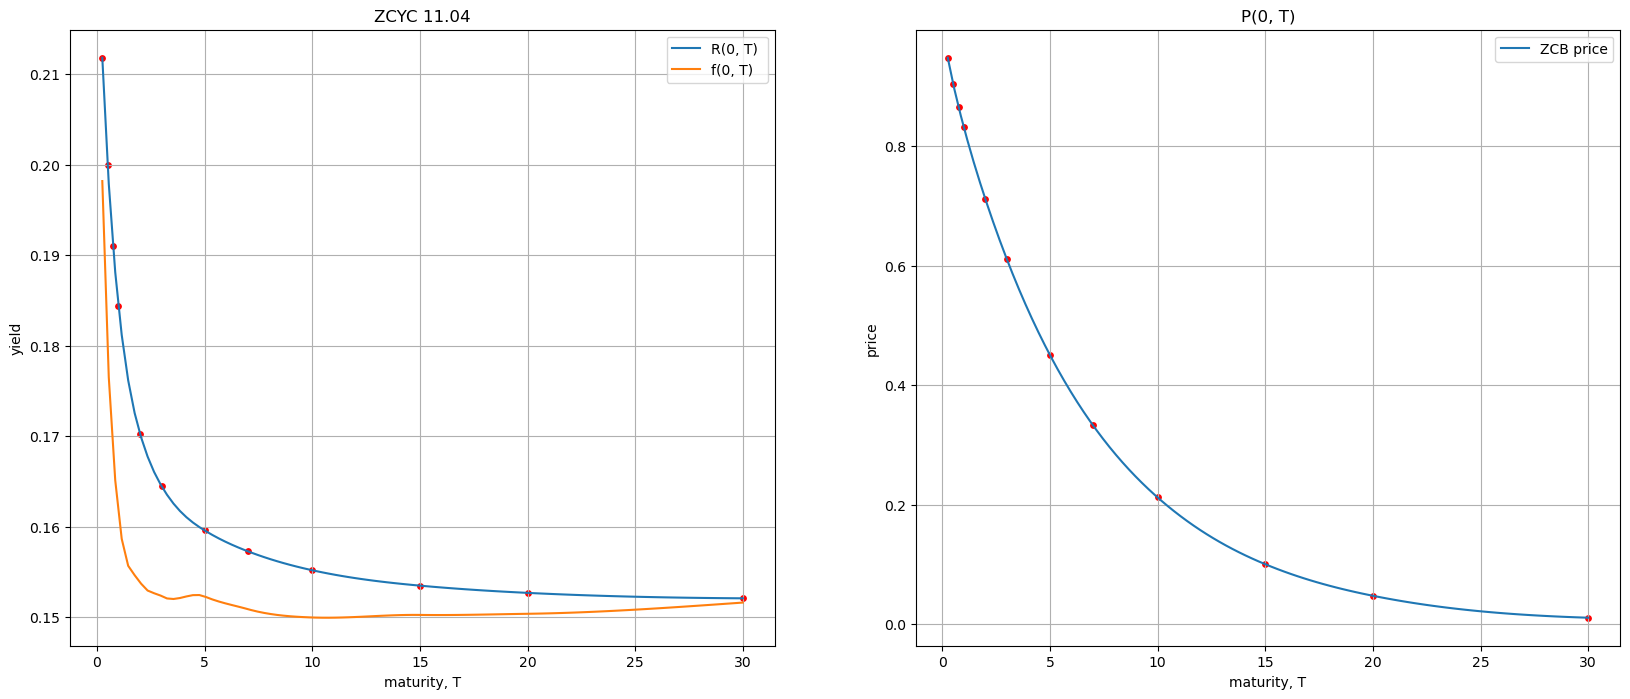

In [3]:
#Data from MOEX ZCYC
maturities = jnp.array([0.25, 0.5, 0.75, 1, 2, 3, 5, 7, 10, 15, 20, 30])
yields = jnp.array([21.18, 19.99, 19.1, 18.44, 17.03, 16.45, 15.96, 15.73, 15.52, 15.35, 15.27, 15.21]) / 100

#Interpolating using cubic splines; Derivatives declaration
R_spline = create_cubic_spline_interpolator(maturities, yields)
R_spline_der = jax.grad(R_spline)
R_spline_2der = jax.grad(jax.grad(R_spline))
P_spline = create_cubic_spline_interpolator(maturities, jnp.exp(-yields*maturities))
min_maturities, max_maturities = jnp.min(maturities), jnp.max(maturities)
x = jnp.linspace(min_maturities, max_maturities, 100)

#Plotting
plt.figure(figsize = (12, 8))
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 8))
axs[0].plot(x, R_spline(x), label = 'R(0, T) ')
axs[0].plot(x, jax.vmap(R_spline_der)(x)*x + R_spline(x), label = 'f(0, T)')
axs[0].scatter(maturities, yields, s = 15, c = 'red')
axs[0].set_xlabel('maturity, T')
axs[0].set_ylabel('yield')
axs[0].set_title('ZCYC 11.04')

axs[1].plot(x, P_spline(x), label = 'ZCB price')
axs[1].scatter(maturities, jnp.exp(-yields*maturities), s = 15, c = 'red')
axs[1].set_xlabel('maturity, T')
axs[1].set_ylabel('price')
axs[1].set_title('P(0, T)')

for ax in axs:
    ax.grid()
    ax.legend()

Next, to model short rate we use Hull-White model:

$dr(t) = \lambda(\theta(t) - r(t))dt + \eta dW(t)$ - model specification under EMM;

In this model we can calibrate $\theta(t)$ to market data using market prices of ZCB:

$\theta(t) = f(0, t) + \frac{1}{\lambda}\frac{\partial f(0, t)}{\partial t} + \frac{\eta^2}{2 \lambda^2}(1 - e^{-2\lambda t})$, where $f(0, t)$ can be found from ZCYC from above.


To calibrate $\eta$ we need to use market data for IR swaptions/Caps/Floors, that is out of the scope of this notebook.
Calibration of $\lambda$ is optional. 

So, standard values for  $\eta, \lambda$ will be taken.

In [4]:
#Euler discretization for HW model
@jax.jit
def HW_next_step(lambda_, eta, r_prev, theta_prev, dt, z):
    r_next = r_prev + lambda_*(theta_prev - r_prev)*dt + eta*dt*z
    return r_next

#f(0, T)
@jax.jit
def init_forward(T):
    return jax.vmap(R_spline_der)(T)*T + R_spline(T)

#df(0, T)/dT
@jax.jit
def init_forward_der(T):
    return jax.vmap(R_spline_2der)(T)*T + 2*jax.vmap(R_spline_der)(T)

#\theta(t)
@jax.jit
def theta(T, lambda_, eta):
    return 1/lambda_*init_forward_der(T) + init_forward(T) + eta**2/2/lambda_**2*(1 - jnp.exp(-2*lambda_*T))

#Creating HW paths
def get_HW_paths(lambda_, eta, r0, T, N_paths, N_steps, key):
    dt = T/(N_steps-1)

    def step(carry, key):
        t_prev, r_prev = carry
        
        key1 = jax.random.split(key, 1)
        z = jax.random.normal(key, (N_paths, ))

        theta_prev = theta(t_prev + dt, lambda_, eta)
        r_next = HW_next_step(lambda_, eta, r_prev, theta_prev, dt, z)
        t_next = t_prev + dt
        return (t_next, r_next), r_next

    keys = jax.random.split(key, (N_steps-1, ))
    r_init = jnp.full(N_paths, r0)
    t_init = jnp.full(N_paths, 0.0)
    _, r = jax.lax.scan(step, (t_init, r_init), keys)

    return jnp.vstack((r_init, r)).T

get_HW_paths = jax.jit(get_HW_paths, static_argnums=(4, 5))

In [5]:
%%time
N_paths = 200000
N_steps = 500
lambda_ = 0.1
eta = 0.01
r0 = R_spline(0.0)
T = 30
key = jax.random.key(37)

r = get_HW_paths(lambda_, eta, r0, T, N_paths, N_steps, key)

CPU times: user 1.9 s, sys: 588 ms, total: 2.49 s
Wall time: 2.37 s


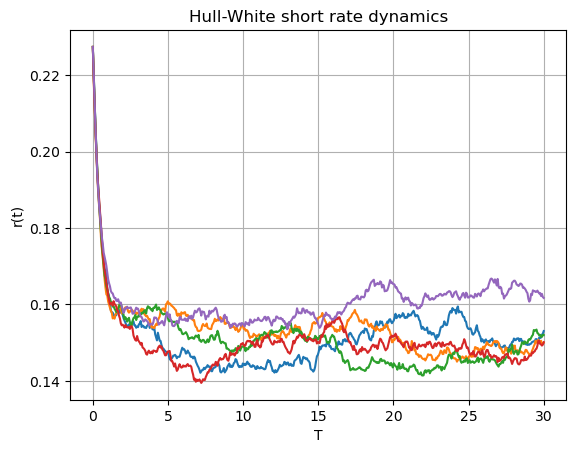

In [6]:
t = jnp.linspace(0, T, N_steps)
plt.plot(t, r[:5, :].T)
plt.title('Hull-White short rate dynamics')
plt.xlabel('T')
plt.ylabel('r(t)')
plt.grid()
plt.show()

Given short-rate paths we can estimate ZCB prices. They should be equal to those that are implied by ZCYC.

$P(0, T) = \mathbb{E}_Q\left[e^{-\int_0^T r(s)ds} |\mathcal{F}_0\right]
\approx \frac{1}{N_{paths}}\sum\limits_{i = 1}^{N_{paths}}e^{-\int_0^T r_i(s)ds}$

In [7]:
@jax.jit
def compute_int(r, t):
    return jax.scipy.integrate.trapezoid(r, t)

#vectorized computation of integrals
integrals = jax.vmap(compute_int, in_axes=(0, None))

zcb_prices = jnp.zeros_like(maturities)

for i, T in enumerate(maturities):
    r = get_HW_paths(lambda_, eta, r0, T, N_paths, N_steps, key)
    t = jnp.linspace(0, T, N_steps)
    tmp = integrals(r, t)
    
    zcb_prices = zcb_prices.at[i].set(jnp.mean(jnp.exp(-tmp)))

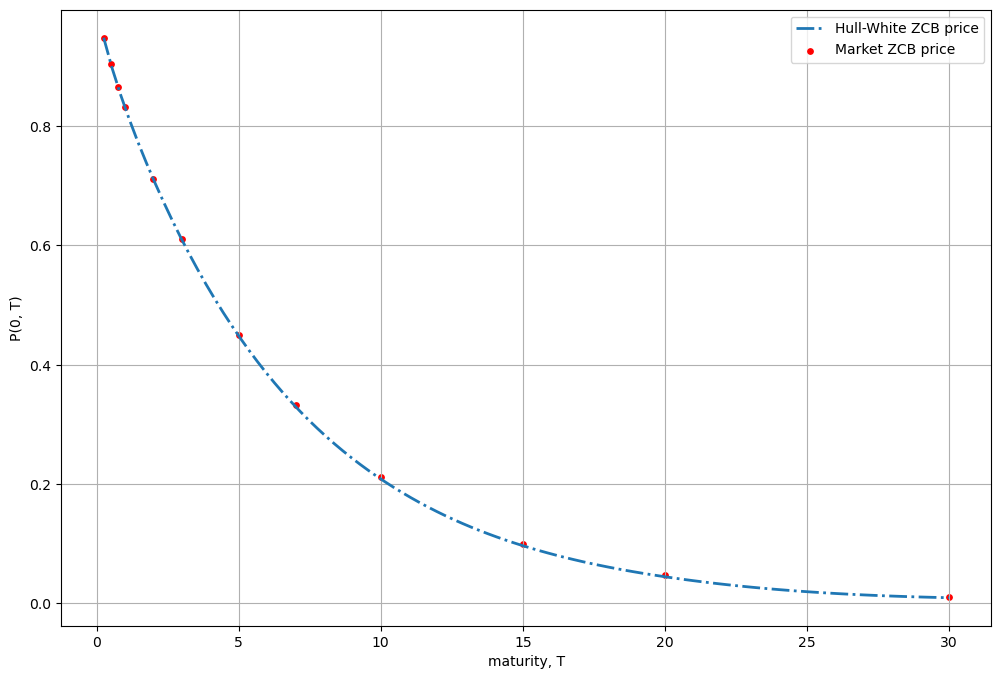

In [8]:
P_hw_spline = create_cubic_spline_interpolator(maturities, zcb_prices)


plt.figure(figsize = (12, 8))
plt.plot(x, P_hw_spline(x), label = 'Hull-White ZCB price', lw = 2, ls = '-.')
plt.scatter(maturities, jnp.exp(-yields*maturities), s = 15, c = 'red', label = 'Market ZCB price')
plt.xlabel('maturity, T')
plt.ylabel('P(0, T)')
plt.grid()
plt.legend()

One can observe that calibrated Hull-White model correctly reproduce ZCB prices and thus can be used to price IR derivatives.